<a href="https://colab.research.google.com/github/MAClaassen/python_course/blob/main/2022_IDSP_MVS_III_Wk_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Multivariate Statistics III: Pt 1- Two-way ANOVA

## 0.0.0 Action Load Basic Libaries

In [ ]:
%matplotlib inline


import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import sklearn as skl
import scipy as sci
import scipy.io as sio


#configure the plotting defaluts
plt.rcParams['figure.figsize'] = [15.256 , 6.024]
plt.rcParams['figure.dpi'] = 300 

#### 0.1 Import the statsmodels package

We are using the Stats Models libary as it let's us explictly write the statistical model using the same syntax as R.  



**note** OLS stands for ordinary least squares, which is the basic fitting techniqe which most fitting is based off of.

In [ ]:
# new libaries for running annova tests

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

data_path='/content/drive/MyDrive/2022_SFC_IDSP/datasets/'


results_path='/content/drive/My Drive/2022_SFC_IDSP/Week_5/'

Mounted at /content/drive/


#### 0.2 Example: load and inspect the data preparing for ANOVA

load the '2022_IDSP_wk4_fuel_data.xlsx'.



In [ ]:
simple_mpg=pd.read_hdf(data_path+'IDSP_wk4_fuel_econ_filtered.h5')
simple_mpg.dtypes

year                 int64
make              category
model             category
VClass            category
trany             category
drive             category
eng_dscr          category
cylinders          float64
displ              float64
fuelType            object
city08               int64
UCity              float64
highway08            int64
UHighway           float64
co2TailpipeGpm     float64
dtype: object

## 1.0 Introduction

Examine the boxen plot$\small{^1}$ below produced using the libary **Seaborn**$\small{^2}$. It shows the distribution of the emisssions data as both a function of the 'drive train' and of the 'fuel type'.

From this figure we can observe that the CO$_2$ emissions within each drive type has signifficnaly more structure when you further split it up by fuel type. The question becomes, which of these splits are statistically signifficant and which can be considered the same group from the perspective of the two variables which we are using to describe the data. We will explore that in this lecture using the **Two-way ANOVA** test.



---


$\small{^1}$ a form of box plot showing more information about quantiles.

$\small{^2}$ Seaborn is a useful plotting libary to start becoming familiar with. While it prodces a wider arrange of default plots compared to either the built in tools of pandas or matplotlib, it is still just based on matplotlib. so you will be able to leverage many of the same commands in a hybrid manner.

In [ ]:
simple_mpg.columns

Index(['year', 'make', 'model', 'VClass', 'trany', 'drive', 'eng_dscr',
       'cylinders', 'displ', 'fuelType', 'city08', 'UCity', 'highway08',
       'UHighway', 'co2TailpipeGpm'],
      dtype='object')

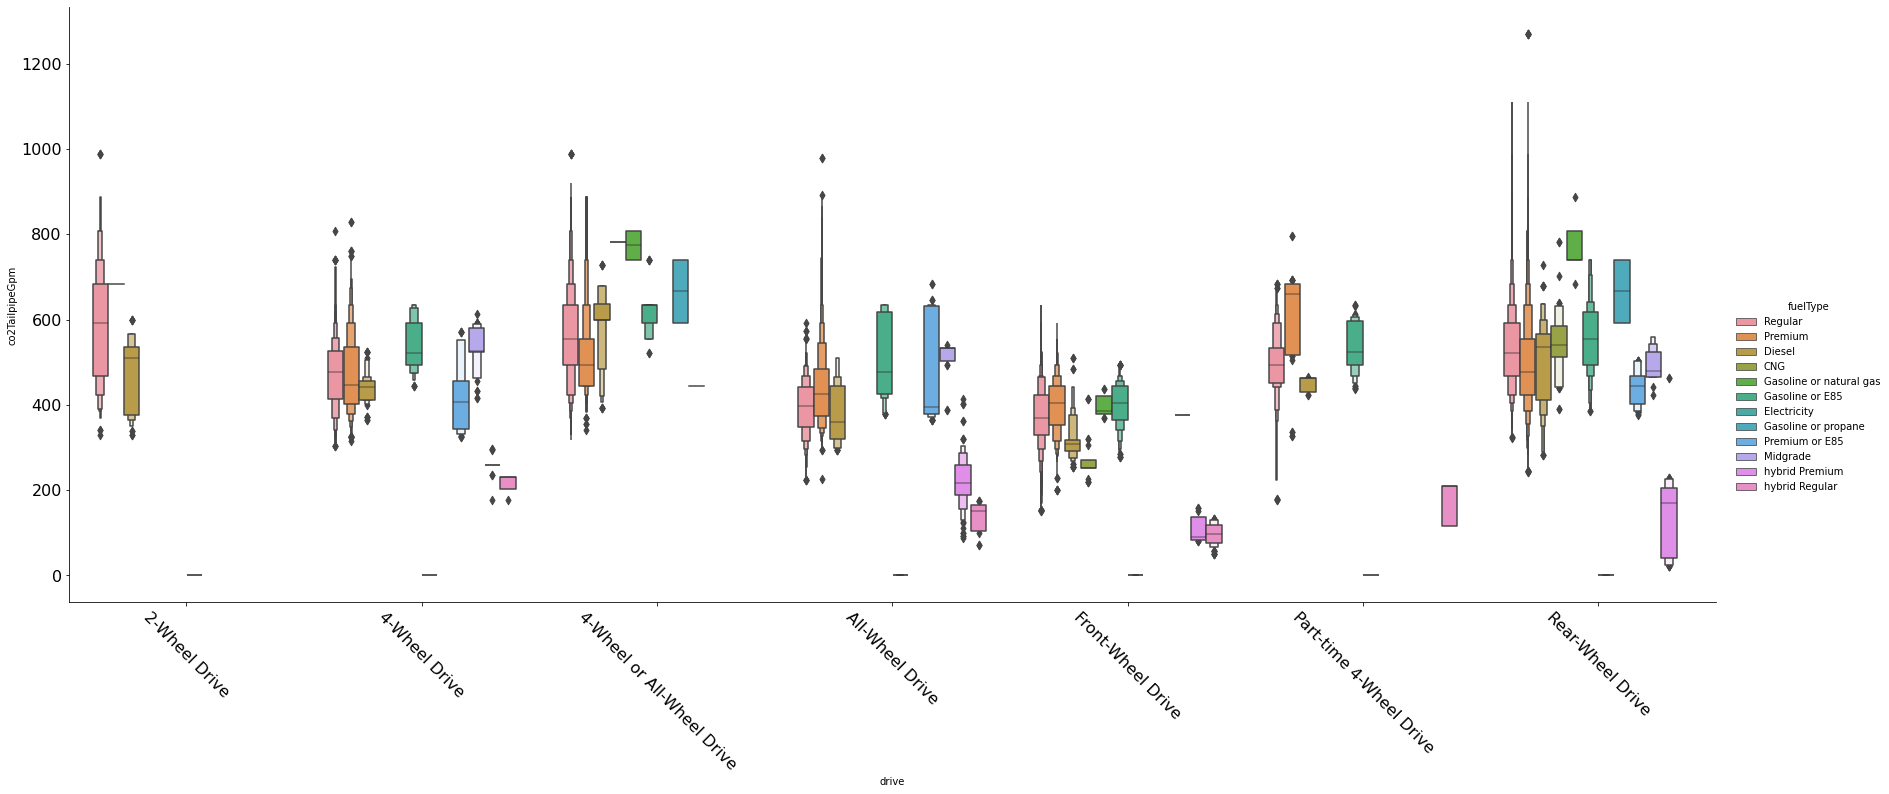



## 1.1 The Two-way ANOVA test

In Lecture 4.1 we introduced the **One-way ANOVA**, as a way to test the responce variable means of three or more groups in a single catagory of  data.

The **Two-way ANOVA** also tests the *hypothesis*:

$H_0 : μ_0 = μ_1 = μ_2= μ_3...= μ_n.$


But now, the test examines the responce variable mean as a function of two cataorical variables or **two factors** instead of just a single variable.  

Remember that in the one-way ANOVA test we examined the question if distribution of CO$_2$ emissions of cars sold in the US from 1984- 2021 could be understood in terms of the differnt classifications of drive train.  The conclusion of that was genrally yes, but some catagories had average emissions which made them statistically similar. 

As not all of the variabialty could be explained by the drive train catagorical variable classifaction (remember some of those groups were statistically similar).  This means that to really understand the problem, one could continue repeating the test on each catagorical variable independently, but really it would make more sense to try and screen the data in terms multiple catagorical variables.  

The overall mathmatical formalism generalises directy from the two catagory case, but with each additionall term becomes incressingly complex.$^*$ 



---


$^*$  The full n-dimensional concept is sometimes called MANOVA for **Many-way Analysis of Varience**, though it can just simply be refered to as ANOVA.




### 1.1.1 Understanding what the two way ANOVA tells us

As stated above a two-way ANOVA test examines if the variation of the means in the responce variable can be understood as being a function of two different and **independant** catagorical variables.$^*$

To be statistically differnt we want both variables to **fail** the test since this means that they signifficantly contribute to variation of responce variable means that we observe. We pointed this out in the Lecture 4.1 on the One-way ANOVA, but here is it more explicit, that the goal of this analysis is to find variables which are different. 

Further, as we are now thinking about the responce variable as a function of two input variables, we need to think about how we want to **model** the system.



---
$^*$ In terms of our data, you can observe that the engine displacement ('displ') has the same general trend as the number of cylinders.  This is bacuase how much air and fuel an engine can move is a fucntion of the number of cylinders. It becomes incresingly hard to discplace more fuel with out increaseing the number of cylinders. In this case these two variables are dependant on one another.


## 1.2 The Linear Statistical Models for ANOVA

In terms of this course, statistics and machine learning more gernerally the term **model** refers to development of mathmatical description of the data. This is done with out consideration for underlying physical processes. In other words we look at the data and see what relationships can we pick out. This is opposed to developing a physical model and then testing to see if the data fits that model. This is the example of **data driven** analysis.

For most of the course we will concern ourselves with **linear models**. Linear in this case means that each of the terms in the model below is not raised to a higher power (i.e. like being squared). 

A linear model for a two factor problem takes the form:

$\mu _{{ij}}(a,b)=\mu +\alpha _{i}(a)+\beta _{j}(b)+\gamma _{{ij}}(a*b)$


Where:



*   $\mu _{{ij}}$ is the mean for the group of measurments combined by the two variables
*   $μ$ is the **grand mean** of all the data
*   $\alpha _{i}$ are additive effects for the the first catagory
*  likewise $\beta _{j}$ are additive effects for the the second catagory
* and $\gamma _{{ij}}$ the additive effects for the interaction of the two factors.

In statistics the **interaction** of two (or more variables) needs to be thought of the interaction being more than the sum of the two parts. The simplist tool to combine two variables to produce something greater than the sum is to multiply them together. Hence the $γ$ term is conceived of as multiplication of the two inital summative terms.





#### 1.2.1  Building a liner model for our data

So to make this concreate based on the data that we have been looking at we will build a model that looks like this:

$ \mu_{emissions}( drive, fuel) = μ_{overall}+ \alpha _{drive} + \beta _{fuel type} +\gamma _{drive * fuel type}$

Note the equation above is a linear equation, as each term is lineraly added to the other terms. Even though the $\gamma$ term is a multiplication of two other terms, we treat it as a liner factor.

We will first use the ANOVA anlayis to determine which of these terms contributes signifficantly to variation of the data


In the ANOVA analysis we will then again examine the sums of squares for each of these groups and by examiing their differences be able to tell is all the means are the same, or do we have particualr variables which explain the variations we are observing.


Let's now build this into our code and see what we discover.

#### 1.2.2 Example: Code the formula and build the model

In [ ]:
formula = 'co2TailpipeGpm ~ C(fuelType) + C(drive) + C(fuelType):C(drive)'
#formula2 = 'co2TailpipeGpm ~ C(drive) + C(fuelType) + C(fuelType):C(drive)'


model = ols(formula, simple_mpg).fit()


#### 1.2.3: Example Examine the residuals with a QQ plot

A **residual** is the difference between the model and the measured data. Overall all in data science we look to minimise these differences. The smaller they are better we know our model works to explain the distribution.

Below is a Quantile-Quantile plot (aslo called a QQ plot) which looks at the quantiles of the data compared to the qauntiles of a tehoretical distribution. Here we compare to Student T-distribution.

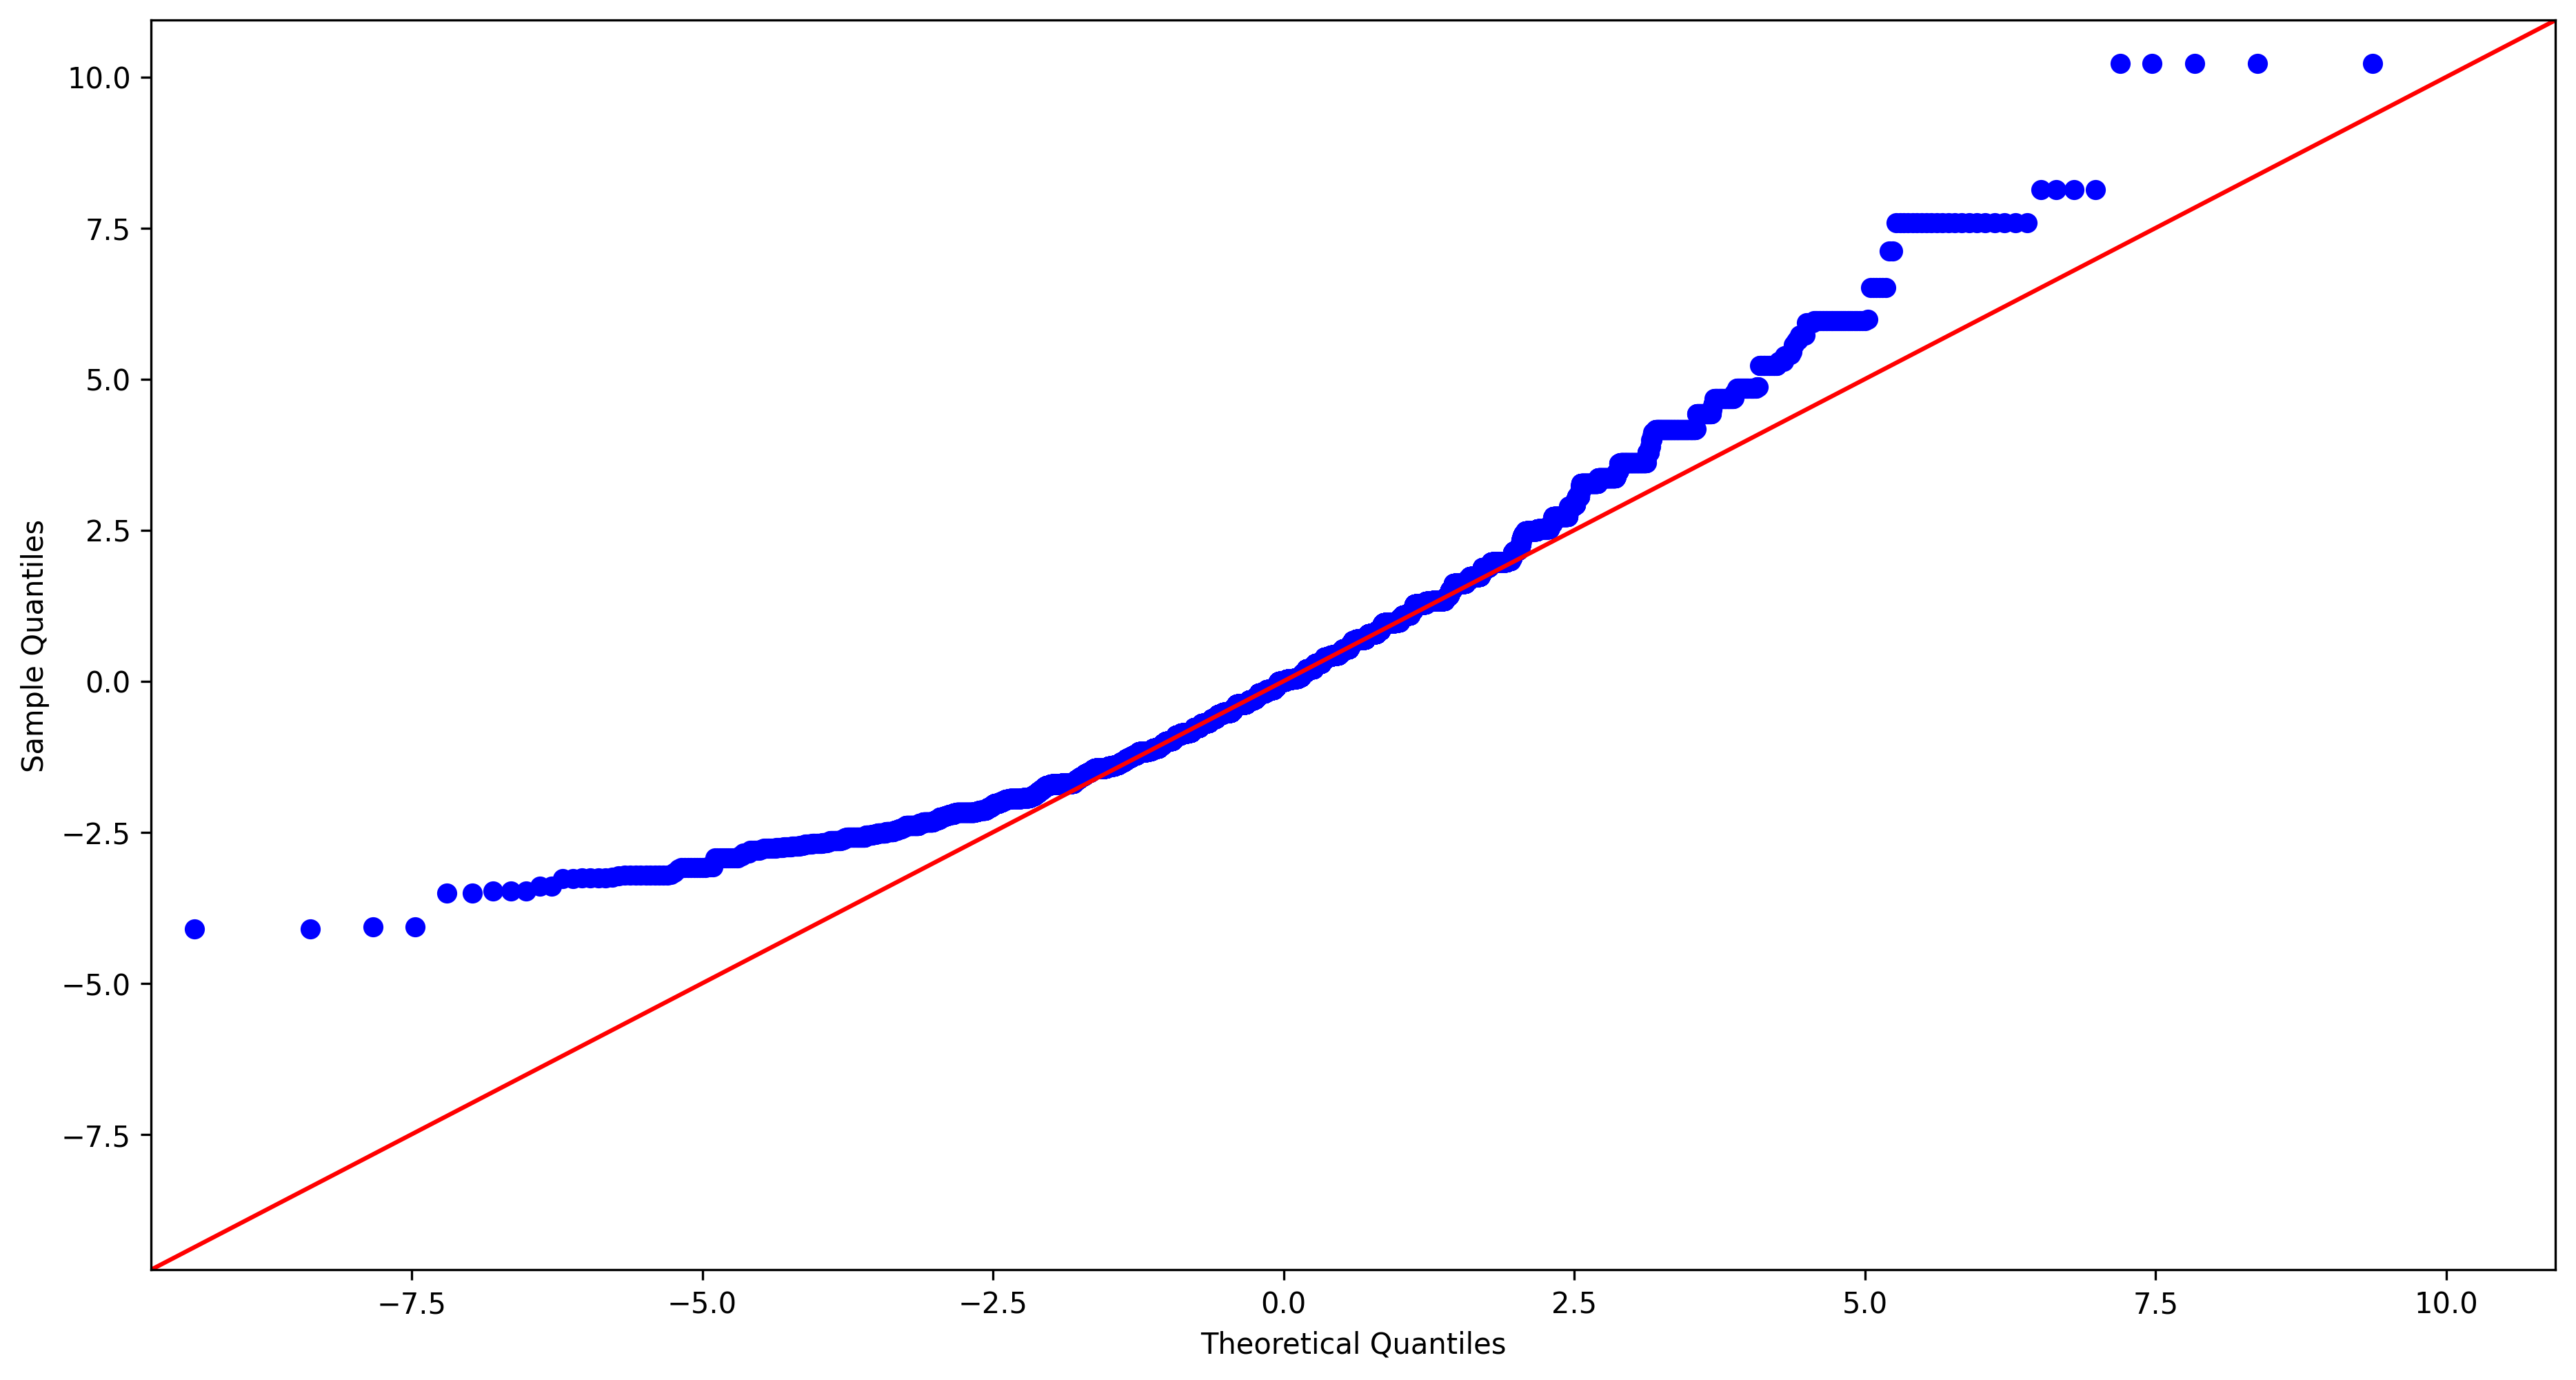

<Figure size 4576.8x1807.2 with 0 Axes>

In [ ]:
from IPython.core.pylabtools import figsize
res = model.resid 
fig,ax=plt.subplots(figsize=(15,8))
sm.qqplot(res, sci.stats.t, fit=True, line="45", ax=ax)
plt.show()

plt.savefig(results_path+'anova_fuel_drive_qqplot')

#### 1.2.4 Comments on QQ-plot insights - All models are wrong...

In a QQ-plot one wants the the blue dots above to both form a linear line and be on top of the red theoretical line( or at least as a line parallel to the theoretical distribution). 

Above we can see that the center of the distribution lies on the line, say that for that region of the data, the model is a good fit. But as we move further away from the liner model, the data gets incresingly poorly described by the model.

This brings to mind the [quote generally atributed to George Box](https://en.wikipedia.org/wiki/All_models_are_wrong):

> All models are wrong but some might be useful.

The real quote that he wrote in 1976, I think gets more towards the key of what a pragmatic scientist / engineer/ researcher needs to keep in mind

> Since all models are wrong the scientist must be alert to what is importantly wrong. It is inappropriate to be concerned about mice when there are tigers abroad.

In other words, if we are tying to gain insight into a hard problem, accept that your model has flaws, know what they are but keep using it until you do not gain insight into the system you are studying.

With that in mind, lets push our model thrugh the two-factor ANOVA to see what insight we can gain about car emissions based on the fuel it uses and the type of drive train.

## 1.3 Runing the ANOVA analysis.

Below you will see to run the analysis in statsmodels is fairly direct your input the model above, and then specify what **type** of ANOVA to run.


### 1.3.1 Type I, II and III Sum of Squares methods

In this post on the [R-bloggers site](https://www.r-bloggers.com/2011/03/anova-%E2%80%93-type-iiiiii-ss-explained/) the concept of Type of ANOVA is explained.

The author discusses that the three types are differnt methods for how to calcualte the differnt **sums of squares**  used in determine if the two groups contribute to describeing the variations in the data.

I will not present the full set of equations for the different Sums of Squares for each method, as the post does some of that and for those really interested I will refer you to the Wikepedia articale on [ANOVA and it's references](https://en.wikipedia.org/wiki/Analysis_of_variance) as astart.$^1$

Instead, let's point out the three key differences and assumtpions about each approach:



*   **Type I** calcualtes the SS of each factor in a specific order. Does not matter if data is **balenced**, but will produce different results is data is **unbalenced**.
*   **Type II** often the **default** approach. If there is no interaction then this is prefered method as it will tell you wich of the two factors contributes the most. But it does assume a **balenced** data set. However, [Langsurd (2003)](https://link.springer.com/article/10.1023/A:1023260610025) argues that Type II is approriate for unbalenced and interacting models.
*   **Type III** If interactions are signifficant and the data is unbalenced then this will provide the most insight.

The blog notes '...if interactions are present (generally speaking, if a significant interaction is present, the main effects should not be further analysed.' So it is important to first figure out if there are significant interactions between the factors.

The key bit being that if the data is balenced, all three methods will produce the same result (as the factors are othogonol).


In our case we know that our groups are not all the same size, so care needs to be taken and we can observe how our conclusions change based on the outputs of the ANOVA.

---
$^1$ also a good test for many statistics ideas would be Box, Hunter and Hunter *Statistics for Experimenters*.



### 1.3.2 Example: code for running all three types of the two-way ANOVA.

In [ ]:
aov_table1 = anova_lm(model, typ=1)
aov_table1

,df,sum_sq,mean_sq,F,PR(>F)
C(drive),6.0,2.295016e+08,3.825027e+07,4556.952760,0.0
C(fuelType),11.0,9.169771e+07,8.336155e+06,993.129465,0.0
C(fuelType):C(drive),66.0,1.588715e+07,2.407144e+05,28.677554,0.0
Residual,43544.0,3.655007e+08,8.393825e+03,NaN,NaN


In [ ]:
aov_table2 = anova_lm(model, typ=2)
aov_table2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 7
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 66, but rank is 50
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(drive),1.102588e+08,6.0,2.189284e+03,0.0
C(fuelType),-6.127922e-02,11.0,-6.636829e-07,1.0
C(fuelType):C(drive),1.126372e+08,66.0,2.033190e+02,0.0
Residual,3.655007e+08,43544.0,NaN,NaN


In [ ]:
aov_table3 = anova_lm(model, typ=3)
aov_table3

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 66, but rank is 50
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,3.955773e+06,1.0,471.271818,6.041799e-104
C(drive),1.780951e+06,6.0,35.362331,6.211661e-43
C(fuelType),1.406661e+07,11.0,152.348032,0.000000e+00
C(fuelType):C(drive),1.126372e+08,66.0,203.319046,0.000000e+00
Residual,3.655007e+08,43544.0,NaN,NaN


### 1.3.3 Conclusions from ANOVA

**First** we are observing the warning above since several of the groups formed by the two factors (drive and fuel type) have a single or no elements (see the cross table below). 

**Second** while as per the cross tab below, we are unbalenced, **all three modes of ANOVA Sums of Squares show that the interaction of between fuel type and drive train are significant**.

## 1.4 Actions for Two-way ANOVA

#### 1.4.1 Action create a subset of the data that will be the focus of your two-way ANOVA.

This could be be a set of years, a subset of fuel types, drive trains or vechile classes, number of cylinders etc (or combination there of).

this will be an exercise using the ```.loc``` and the logical operators.

The idea being that we want you to be able to have a slightly more tractable dataset than what was presented above.

Explain why you are making these decisions.  ie what question do you want to understand?

In [ ]:
# I am interested in looking at how fuel type impacts average MPG across the years. 

# calculate the average mpg for city and highway
simple_mpg['average_mpg08']=(simple_mpg['city08']+simple_mpg['highway08'])/2

In [ ]:
# Checking the range of year
# maximum value
simple_mpg['year'].max()

2023

In [ ]:
# maximum value
simple_mpg['year'].min()

1984

In [ ]:
# categorizing year
simple_mpg['year_cat'] = pd.cut(simple_mpg['year'], bins=[1975, 1985, 1995, 2005, 2015, 2025], include_lowest=True, 
                                labels=['1975-1985', '1985-1995', '1995-2005', '2005-2015', '2015-2025'])

In [ ]:
simple_mpg['fuelType'].value_counts()

Regular                    26918
Premium                    13245
Gasoline or E85             1371
Diesel                      1075
Electricity                  361
hybrid Premium               192
Midgrade                     142
Premium or E85               127
hybrid Regular                82
CNG                           60
Gasoline or natural gas       20
Gasoline or propane            8
Name: fuelType, dtype: int64

In [ ]:
# selecting the categories with the highest amount of data available (which also removes some overlapping categories)
simple_mpg_select = simple_mpg[(simple_mpg['fuelType']!= 'CNG') & (simple_mpg['fuelType']!= 'hybrid Premium') & 
                  (simple_mpg['fuelType']!= 'Midgrade') & (simple_mpg['fuelType']!= 'Premium or E85') &
                  (simple_mpg['fuelType']!= 'hybrid Regular') & (simple_mpg['fuelType']!= 'Gasoline or natural gas') &
                  (simple_mpg['fuelType']!= 'Gasoline or propane')]

simple_mpg_select['fuelType'].value_counts()         

Regular            26918
Premium            13245
Gasoline or E85     1371
Diesel              1075
Electricity          361
Name: fuelType, dtype: int64

In [ ]:
simple_mpg_select.to_excel(results_path+'simple_mpg_select.xlsx', index=False)

#### 1.4.2 Action Select a responce variable (emissions, city mpg, highway mpg, average mpg) and two catagorical variables. 

Plot these up using the boxen plot from seaborn like at the begining of 1.0 to see how these two catagories work at describing the data.


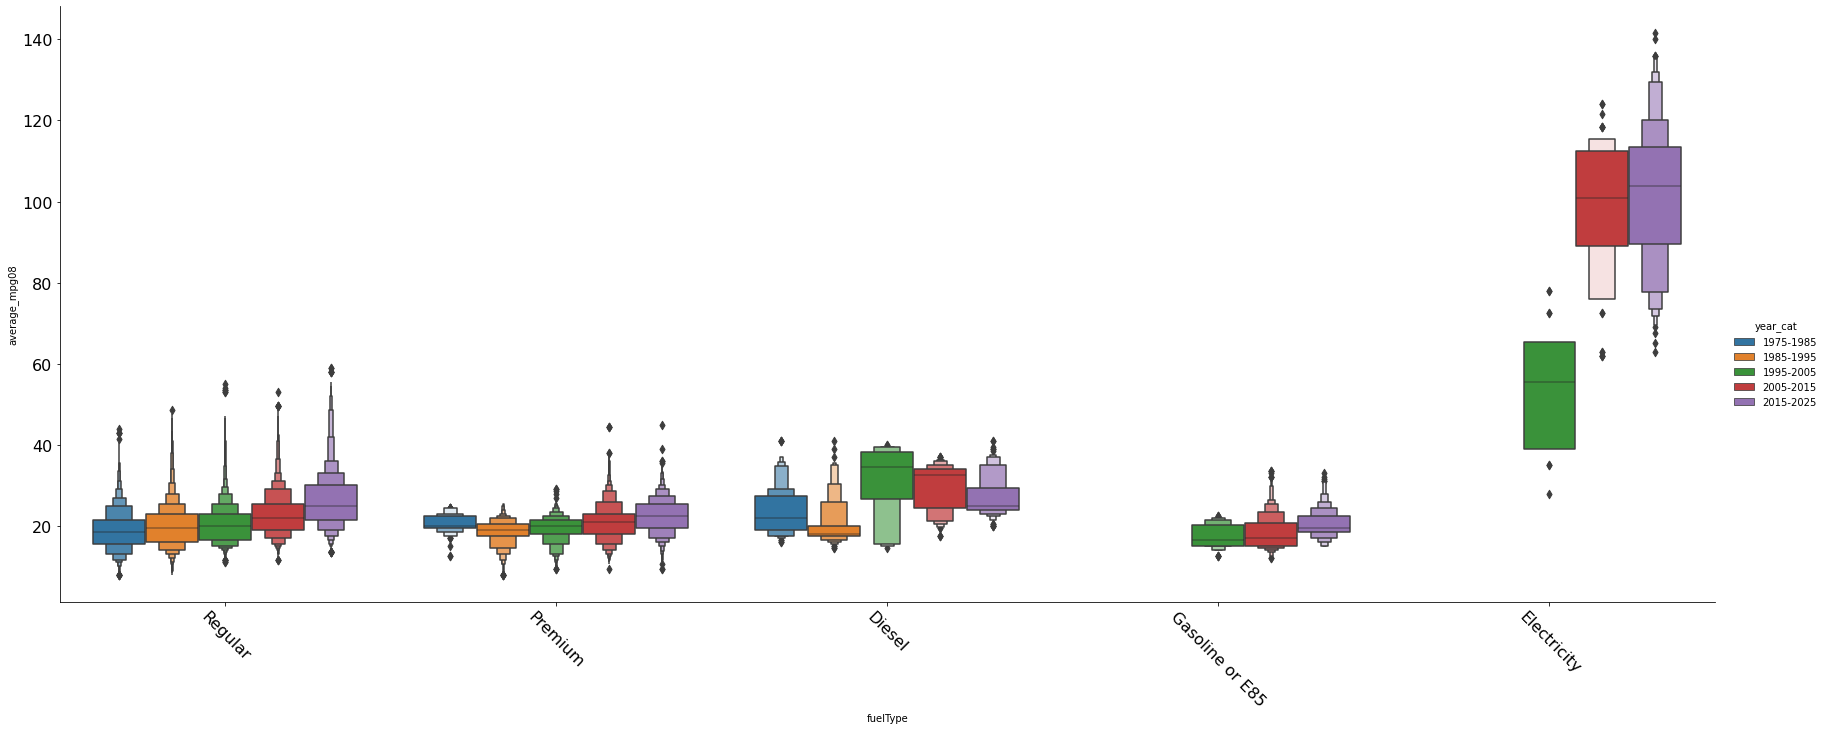

In [ ]:
sns.catplot(data=simple_mpg_select, kind='boxen', x='fuelType', y='average_mpg08',hue='year_cat',
             height = 9, aspect=24/9)
plt.xticks(rotation=-45)
plt.tick_params(labelsize=16)


#### 1.4.3 Action Build a linear model for the system, and examine how well it performs with the QQ-plot

example code in section 1.2.3

In [ ]:
formula = 'average_mpg08 ~ C(fuelType) + C(year_cat) + C(fuelType):C(year_cat)'

In [ ]:
model = ols(formula, simple_mpg_select).fit()

Model is not perfect but good enough. 

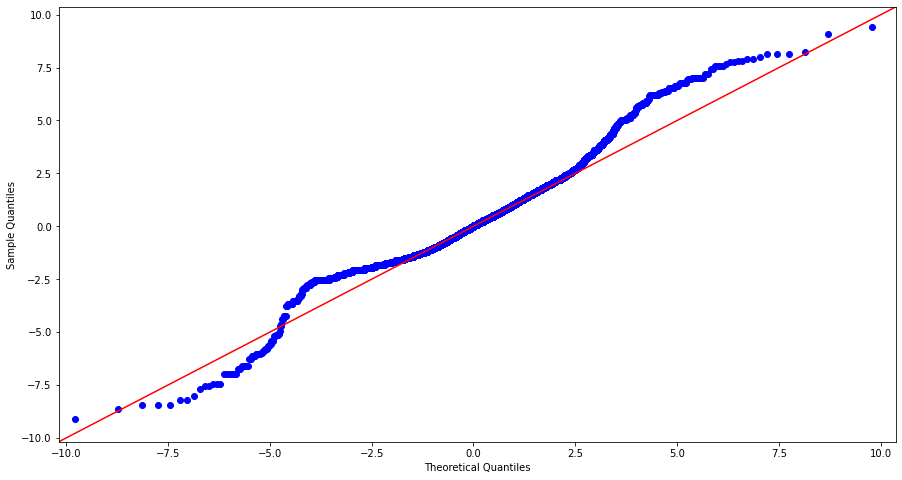

In [ ]:
from IPython.core.pylabtools import figsize
res = model.resid 
fig,ax=plt.subplots(figsize=(15,8))
sm.qqplot(res, sci.stats.t, fit=True, line="45", ax=ax)
plt.show()

#### 1.4.4 Run the ANOVA function with the correct sum of square type selected 
Determine: 

  a) which factors are important and 
  
  b) if the interaction is statistically significant

Running the ANOVAs shows that the interacton is significant no matter what model is run. 

Also both main effects are statistically significant. 

In [ ]:
aov_table1 = anova_lm(model, typ=1)
aov_table1

,df,sum_sq,mean_sq,F,PR(>F)
C(fuelType),4.0,2.197779e+06,549444.748461,20260.013702,0.0
C(year_cat),4.0,1.566420e+05,39160.490794,1443.988831,0.0
C(fuelType):C(year_cat),16.0,4.785737e+04,2991.085620,110.292137,0.0
Residual,42949.0,1.164762e+06,27.119663,NaN,NaN


In [ ]:
aov_table1 = anova_lm(model, typ=2)
aov_table1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 14
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(fuelType),2.295383e+05,4.0,2115.976589,0.0
C(year_cat),3.280024e+05,4.0,3023.658119,0.0
C(fuelType):C(year_cat),2.108391e+06,16.0,4859.000868,0.0
Residual,1.164762e+06,42949.0,NaN,NaN


In [ ]:
aov_table1 = anova_lm(model, typ=3)
aov_table1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 14
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,1.443267e+05,1.0,5321.846906,0.000000e+00
C(fuelType),4.072035e+05,4.0,3753.766277,0.000000e+00
C(year_cat),1.701173e+04,4.0,156.821011,1.835173e-133
C(fuelType):C(year_cat),2.108391e+06,16.0,4859.000868,0.000000e+00
Residual,1.164762e+06,42949.0,NaN,NaN


#### 1.4.5 Action: Start a report thread

Create a discussion thread on this [Moodle Forum](https://moodle.gla.ac.uk/mod/forum/view.php?id=2877349).

The other two parts of this weeks work will combine with this notebooks activities to form a mini-repport.  So each of your other activites will need to be posted as relies to the thread which you start here.